In [4]:
!pip install langchain langchain_community
!pip install neo4j
!pip install groq
!pip install -U --quiet langchain-groq
!pip install langchain_experimental
#!pip install together
!pip install langchain_openai
!pip install qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.6/2

In [5]:
import os
from langchain.graphs import Neo4jGraph
import requests
from bs4 import BeautifulSoup
import pandas as pd
from langchain.chains import GraphCypherQAChain
from langchain.chat_models import ChatOpenAI
from langchain_groq import ChatGroq


neo4j_url = ""
neo4j_username = ""
neo4j_password = ""


In [7]:
## LOAD DATA

data_news=pd.read_csv("/content/Final_Mpox_Data_Adjusted.csv")
data_news.head()
news_content = list(data_news["new_content"])

In [36]:
data_news.head()

,Unnamed: 0,url,country,Symptoms,Transmission,Organization,Virus,Location,Label,new_content
0,0,https://www.yumasun.com/news/two-cases-of-mpox...,MX,"Swollen Lymph Nodes, Fever, Rash","Skin-to-Skin, close contact",Ministry of Health of Mexico,Mpox,Mexico,True,"Thank you for reading!\n\nPlease log in, or si..."
1,1,https://en.mercopress.com/2024/08/29/case-in-c...,AR,"fever, rash, muscle aches, headache","Skin-to-Skin, close contact","WHO, World Health Organization","Mpox, Monkeypox",Argentina,True,"Case in Comodoro Rivadavia not mpox, lab tests..."
2,2,https://www.thestar.com.my/news/nation/2024/08...,MX,"fever, muscle aches, swollen lymph nodes, head...","Skin-to-Skin, close contact",WHO,"Mpox, Monkeypox",Mexico,True,"JOHOR BARU: Johor, known as the southern gatew..."
3,3,https://latinamericanpost.com/analysis-en/arge...,AR,fever,"Contaminated Objects, close contact","WHO, World Health Organization","Mpox, Monkeypox, COVID-19",Argentina,True,Argentina’s Pope Francis has urged governments...
4,4,https://www.stabroeknews.com/2024/08/21/news/r...,AR,fever,close contact,"WHO, World Health Organization",Mpox,Argentina,True,BUENOS AIRES (Reuters) – Argentine authorities...


In [22]:


TEMPERATURE_MODEL=0.3

llm_llama37b = ChatGroq(
    model="llama3-70b-8192",
    temperature=TEMPERATURE_MODEL,
    groq_api_key="",
)

llm_mixtral7b = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=TEMPERATURE_MODEL,
    groq_api_key="",
)

llm_gemma7b = ChatGroq(
    model="gemma-7b-it",
    temperature=TEMPERATURE_MODEL,
    groq_api_key="",
)

llm_llama8b = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=TEMPERATURE_MODEL,
    groq_api_key="",
)

In [10]:
from qdrant_client import QdrantClient
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field,constr, conint
from typing import Union
from langchain.vectorstores import Qdrant


class NewsChecker(BaseModel):
    score: Union[constr(strip_whitespace=True), conint(ge=0, le=1)]

In [11]:
QDRANT_CLOUD_URL = ""
QDRANT_API_KEY = ""

client = QdrantClient(url=QDRANT_CLOUD_URL,api_key=QDRANT_API_KEY)

In [20]:
vector_store = Qdrant(client=client,
                      collection_name="mpox_collection",
                      embeddings=OpenAIEmbeddings(model="text-embedding-3-small", api_key="")
                      )
def retrieve_information(query):
        context = vector_store.similarity_search(query=query, k=5)
        return context
retrieve_information("que es mpox?")

[Document(metadata={'source': 'Mpox_information.pdf', 'page': 1, '_id': 'b1412ff9-a7e5-49aa-8b70-aa1be02021c8', '_collection_name': 'mpox_collection'}, page_content='Mpox can be transmitted through close contact with someone who has mpox,'),
 Document(metadata={'source': 'Mpox_information.pdf', 'page': 5, '_id': 'bdaf9088-797e-455d-b043-db10250e715e', '_collection_name': 'mpox_collection'}, page_content='https://www.who.int/news-room/fact-sheets/detail/mpox#:~:text=Common symptoms of mpox are,materials%2C or with infected animals. 6/11'),
 Document(metadata={'source': 'Mpox_information.pdf', 'page': 4, '_id': 'd5662d03-709c-4f6a-b4c2-3dfa7a790c61', '_collection_name': 'mpox_collection'}, page_content='https://www.who.int/news-room/fact-sheets/detail/mpox#:~:text=Common symptoms of mpox are,materials%2C or with infected animals. 5/11'),
 Document(metadata={'source': 'Mpox_information.pdf', 'page': 2, '_id': '1daddb6d-ed67-48f2-8d9b-48dfa9ad4e6e', '_collection_name': 'mpox_collection'}, 

In [13]:
!pip install tqdm


In [23]:
from tqdm import tqdm

model = "mixtral7b"
parser = PydanticOutputParser(pydantic_object=NewsChecker)
template = """
            You are an expert information verification assistant.
            I am going to provide you with a set of verified facts that are considered true.
            Then I will provide you with a news story and your task will be to compare the facts in the news with the true information provided,
            and determine how true the news is on a scale of 0 to 1, where 0 means the news is completely false and 1 means it is completely false.
            completely true. just return the number of score.
            ### Verified information:
            {fact_information}

            ### News to evaluate:
            {new_information}
        """
prompt = PromptTemplate(
  template=template,
  input_variables=["new_information","fact_information"],
  #partial_variables={"format_instructions": parser.get_format_instructions()},
)


result = []

for i in tqdm(news_content[0:100], desc="Processing news content"):
  fact_information = " ".join([i.page_content for i in retrieve_information(query=i)])

  # And a query intended to prompt a language model to populate the data structure.
  prompt_and_model = prompt | llm_llama37b
  output = prompt_and_model.invoke({"new_information":i, "fact_information":fact_information})

  result_check=output.content

  ## validar modulo
  response = llm_llama37b.invoke("Give me the number of score thath the previos modelo chose: just give me the number as a result "+result_check).content
  print(response)
  result.append(response)

Processing news content:   1%|          | 1/100 [00:01<01:47,  1.09s/it]

0


Processing news content:   2%|▏         | 2/100 [00:01<01:23,  1.18it/s]

0.8


Processing news content:   3%|▎         | 3/100 [00:05<03:37,  2.24s/it]

0.8


Processing news content:   4%|▍         | 4/100 [00:29<17:17, 10.81s/it]

0.8


Processing news content:   5%|▌         | 5/100 [00:30<11:30,  7.27s/it]

0.8


Processing news content:   6%|▌         | 6/100 [00:43<14:19,  9.15s/it]

0.8


Processing news content:   7%|▋         | 7/100 [00:51<13:39,  8.81s/it]

0.8


Processing news content:   8%|▊         | 8/100 [00:57<12:10,  7.94s/it]

0.8


Processing news content:   9%|▉         | 9/100 [01:07<13:09,  8.68s/it]

0.83


Processing news content:  10%|█         | 10/100 [01:13<11:25,  7.62s/it]

0


Processing news content:  11%|█         | 11/100 [01:27<14:12,  9.58s/it]

0.95


Processing news content:  12%|█▏        | 12/100 [01:37<14:17,  9.74s/it]

0.8


Processing news content:  13%|█▎        | 13/100 [01:50<15:37, 10.77s/it]

0.8


Processing news content:  14%|█▍        | 14/100 [01:58<14:24, 10.05s/it]

0.9


Processing news content:  15%|█▌        | 15/100 [02:04<12:10,  8.60s/it]

0


Processing news content:  16%|█▌        | 16/100 [02:21<15:55, 11.38s/it]

0.8


Processing news content:  17%|█▋        | 17/100 [02:30<14:41, 10.62s/it]

0.8


Processing news content:  18%|█▊        | 18/100 [02:39<13:34,  9.93s/it]

0.9


Processing news content:  19%|█▉        | 19/100 [02:55<15:56, 11.81s/it]

0.5


Processing news content:  20%|██        | 20/100 [03:03<14:19, 10.75s/it]

0.8


Processing news content:  21%|██        | 21/100 [03:15<14:42, 11.17s/it]

0.8


Processing news content:  22%|██▏       | 22/100 [03:35<17:45, 13.66s/it]

0.8


Processing news content:  23%|██▎       | 23/100 [03:37<13:16, 10.35s/it]

I apologize, but there is no previous model or score to refer to. This is the beginning of our conversation. If you'd like to start a new topic or ask a question, I'm here to help!


Processing news content:  24%|██▍       | 24/100 [03:44<11:55,  9.42s/it]

0.7


Processing news content:  25%|██▌       | 25/100 [03:58<13:10, 10.53s/it]

0.8


Processing news content:  26%|██▌       | 26/100 [04:10<13:34, 11.01s/it]

0.8


Processing news content:  27%|██▋       | 27/100 [04:15<11:24,  9.38s/it]

0.8


Processing news content:  28%|██▊       | 28/100 [04:19<09:17,  7.74s/it]

I apologize, but there is no previous model or score to reference. This is the beginning of our conversation. If you'd like to start a new topic or ask a question, I'm here to help!


Processing news content:  29%|██▉       | 29/100 [04:24<08:06,  6.85s/it]

There is no previous model, so I'll respond with:

0


Processing news content:  30%|███       | 30/100 [04:46<13:16, 11.38s/it]

0.8


Processing news content:  31%|███       | 31/100 [05:05<15:48, 13.75s/it]

0.8


Processing news content:  32%|███▏      | 32/100 [05:06<11:17,  9.97s/it]

0.5


Processing news content:  33%|███▎      | 33/100 [05:11<09:28,  8.48s/it]

I apologize, but this conversation has just started, and there is no previous model or score to report. The result is indeed 0.


Processing news content:  34%|███▍      | 34/100 [05:20<09:15,  8.42s/it]

0.8


Processing news content:  35%|███▌      | 35/100 [05:25<08:12,  7.57s/it]

I apologize, but I think there's been a misunderstanding! This conversation just started, and I didn't provide a news article or a previous model's score. I'm here to help with any questions or topics you'd like to discuss. Please feel free to ask me anything, and I'll do my best to assist you!


Processing news content:  36%|███▌      | 36/100 [05:30<07:11,  6.74s/it]

I apologize, but there is no previous model or score to refer to. This is the beginning of our conversation. If you'd like to start a new topic or ask a question, I'm here to help!


Processing news content:  37%|███▋      | 37/100 [05:41<08:22,  7.98s/it]

0.8


Processing news content:  38%|███▊      | 38/100 [05:59<11:25, 11.05s/it]

0.8


Processing news content:  39%|███▉      | 39/100 [06:01<08:33,  8.42s/it]

0.8


Processing news content:  40%|████      | 40/100 [06:05<07:02,  7.04s/it]

0


Processing news content:  41%|████      | 41/100 [06:11<06:34,  6.69s/it]

0


Processing news content:  42%|████▏     | 42/100 [06:17<06:20,  6.55s/it]

N/A


Processing news content:  43%|████▎     | 43/100 [06:31<08:06,  8.53s/it]

0.8


Processing news content:  44%|████▍     | 44/100 [06:33<06:08,  6.58s/it]

There is no previous model, so I'll respond with:

0


Processing news content:  45%|████▌     | 45/100 [06:38<05:50,  6.37s/it]

0


Processing news content:  46%|████▌     | 46/100 [06:48<06:31,  7.25s/it]

0.8


Processing news content:  47%|████▋     | 47/100 [06:50<05:01,  5.69s/it]

I apologize, but this conversation has just started, and there is no previous model or score to refer to. Therefore, I'll respond with:

0


Processing news content:  48%|████▊     | 48/100 [06:55<04:44,  5.47s/it]

I apologize, but this conversation has just started, and there is no previous model or score to report. The answer is indeed 0.


Processing news content:  49%|████▉     | 49/100 [07:44<15:47, 18.59s/it]

0.9


Processing news content:  50%|█████     | 50/100 [07:45<11:06, 13.33s/it]

0.8


Processing news content:  51%|█████     | 51/100 [08:30<18:42, 22.91s/it]

0.8


Processing news content:  52%|█████▏    | 52/100 [08:31<13:05, 16.36s/it]

0


Processing news content:  53%|█████▎    | 53/100 [08:38<10:29, 13.39s/it]

0.9


Processing news content:  54%|█████▍    | 54/100 [08:46<09:06, 11.89s/it]

0.8


Processing news content:  55%|█████▌    | 55/100 [09:07<11:00, 14.68s/it]

0.8


Processing news content:  56%|█████▌    | 56/100 [09:08<07:45, 10.58s/it]

There is no previous model, so I'll assume you meant to ask for a random score. Here is the result:

0


Processing news content:  57%|█████▋    | 57/100 [09:23<08:28, 11.84s/it]

0.9


Processing news content:  58%|█████▊    | 58/100 [09:32<07:43, 11.04s/it]

0.8


Processing news content:  59%|█████▉    | 59/100 [09:36<06:08,  8.98s/it]

0


Processing news content:  60%|██████    | 60/100 [09:52<07:21, 11.03s/it]

0.8


Processing news content:  61%|██████    | 61/100 [09:54<05:24,  8.32s/it]

I apologize, but there is no previous model or score to report. This is the beginning of our conversation.


Processing news content:  62%|██████▏   | 62/100 [10:15<07:42, 12.17s/it]

0.8


Processing news content:  63%|██████▎   | 63/100 [10:22<06:22, 10.35s/it]

0.8


Processing news content:  64%|██████▍   | 64/100 [10:25<04:52,  8.14s/it]

0.8


Processing news content:  65%|██████▌   | 65/100 [10:29<04:11,  7.18s/it]

0


Processing news content:  66%|██████▌   | 66/100 [10:33<03:31,  6.21s/it]

I apologize, but there is no previous model or score to reference. This is the beginning of our conversation. If you'd like to start a new topic or ask a question, I'm here to help!


Processing news content:  67%|██████▋   | 67/100 [10:48<04:51,  8.84s/it]

0.8


Processing news content:  68%|██████▊   | 68/100 [10:52<03:49,  7.18s/it]

0


Processing news content:  69%|██████▉   | 69/100 [11:03<04:23,  8.51s/it]

0.8


Processing news content:  70%|███████   | 70/100 [11:09<03:54,  7.81s/it]

0.8


Processing news content:  71%|███████   | 71/100 [11:14<03:13,  6.68s/it]

I apologize, but this conversation has just started, and there is no previous model or score to report. The answer is indeed 0.


Processing news content:  72%|███████▏  | 72/100 [11:27<04:06,  8.81s/it]

0.9


Processing news content:  73%|███████▎  | 73/100 [11:31<03:16,  7.27s/it]

0.2


Processing news content:  74%|███████▍  | 74/100 [11:37<03:00,  6.94s/it]

0.8


Processing news content:  75%|███████▌  | 75/100 [11:48<03:25,  8.23s/it]

0.9


Processing news content:  76%|███████▌  | 76/100 [11:50<02:27,  6.13s/it]

I apologize, but there is no previous model or score to report. This is the beginning of our conversation. If you'd like to start a new conversation or ask a question, I'm here to help!


Processing news content:  77%|███████▋  | 77/100 [12:13<04:17, 11.20s/it]

0.8


Processing news content:  78%|███████▊  | 78/100 [12:21<03:47, 10.32s/it]

0.8


Processing news content:  79%|███████▉  | 79/100 [12:28<03:16,  9.35s/it]

0.9


Processing news content:  80%|████████  | 80/100 [12:58<05:12, 15.61s/it]

0.8


Processing news content:  81%|████████  | 81/100 [12:59<03:34, 11.29s/it]

0


Processing news content:  82%|████████▏ | 82/100 [13:20<04:15, 14.17s/it]

0.9


Processing news content:  83%|████████▎ | 83/100 [13:40<04:26, 15.70s/it]

0.9


Processing news content:  84%|████████▍ | 84/100 [13:41<03:01, 11.32s/it]

0


Processing news content:  85%|████████▌ | 85/100 [13:48<02:33, 10.21s/it]

0.9


Processing news content:  86%|████████▌ | 86/100 [13:56<02:10,  9.34s/it]

0.8


Processing news content:  87%|████████▋ | 87/100 [13:59<01:37,  7.50s/it]

0.5


Processing news content:  88%|████████▊ | 88/100 [14:06<01:27,  7.28s/it]

0.8


Processing news content:  89%|████████▉ | 89/100 [14:18<01:36,  8.75s/it]

0.9


Processing news content:  90%|█████████ | 90/100 [14:20<01:07,  6.76s/it]

0.8


Processing news content:  91%|█████████ | 91/100 [14:25<00:55,  6.20s/it]

N/A


Processing news content:  92%|█████████▏| 92/100 [14:31<00:49,  6.14s/it]

0.8


Processing news content:  93%|█████████▎| 93/100 [14:35<00:39,  5.62s/it]

0.8


Processing news content:  94%|█████████▍| 94/100 [14:40<00:32,  5.46s/it]

0


Processing news content:  95%|█████████▌| 95/100 [14:45<00:26,  5.30s/it]

0


Processing news content:  96%|█████████▌| 96/100 [15:02<00:35,  8.80s/it]

0.9


Processing news content:  97%|█████████▋| 97/100 [15:11<00:26,  8.92s/it]

0.9


Processing news content:  98%|█████████▊| 98/100 [15:15<00:14,  7.19s/it]

0


Processing news content:  99%|█████████▉| 99/100 [15:18<00:06,  6.18s/it]

There is no previous model, so I'll assume you want a default value. Here is the result:

0


Processing news content: 100%|██████████| 100/100 [15:23<00:00,  9.24s/it]

I apologize, but there is no previous model or score to report. This is the beginning of our conversation.


In [24]:
data_final = {
    "question":news_content[0:100],
    "true_value":list(data_news["Label"])[0:100],
    "predict_value":result
}


In [25]:
result_final = pd.DataFrame(data_final)
result_final["model"]=model
result_final

,question,true_value,predict_value,model
0,"Thank you for reading!\n\nPlease log in, or si...",True,0,mixtral7b
1,"Case in Comodoro Rivadavia not mpox, lab tests...",True,0.8,mixtral7b
2,"JOHOR BARU: Johor, known as the southern gatew...",True,0.8,mixtral7b
3,Argentina’s Pope Francis has urged governments...,True,0.8,mixtral7b
4,BUENOS AIRES (Reuters) – Argentine authorities...,True,0.8,mixtral7b
...,...,...,...,...
95,Fifth case of monkeypox reported in Rio de Jan...,True,0.9,mixtral7b
96,President Joe Biden and his administration on ...,True,0.9,mixtral7b
97,Failed to extract article: Article `download()...,True,0,mixtral7b
98,Failed to extract article: Article `download()...,True,"There is no previous model, so I'll assume you...",mixtral7b


In [26]:
result_final.to_csv(f"result_fakempox_for_model_{model}_temp_0.3.csv", index=False)

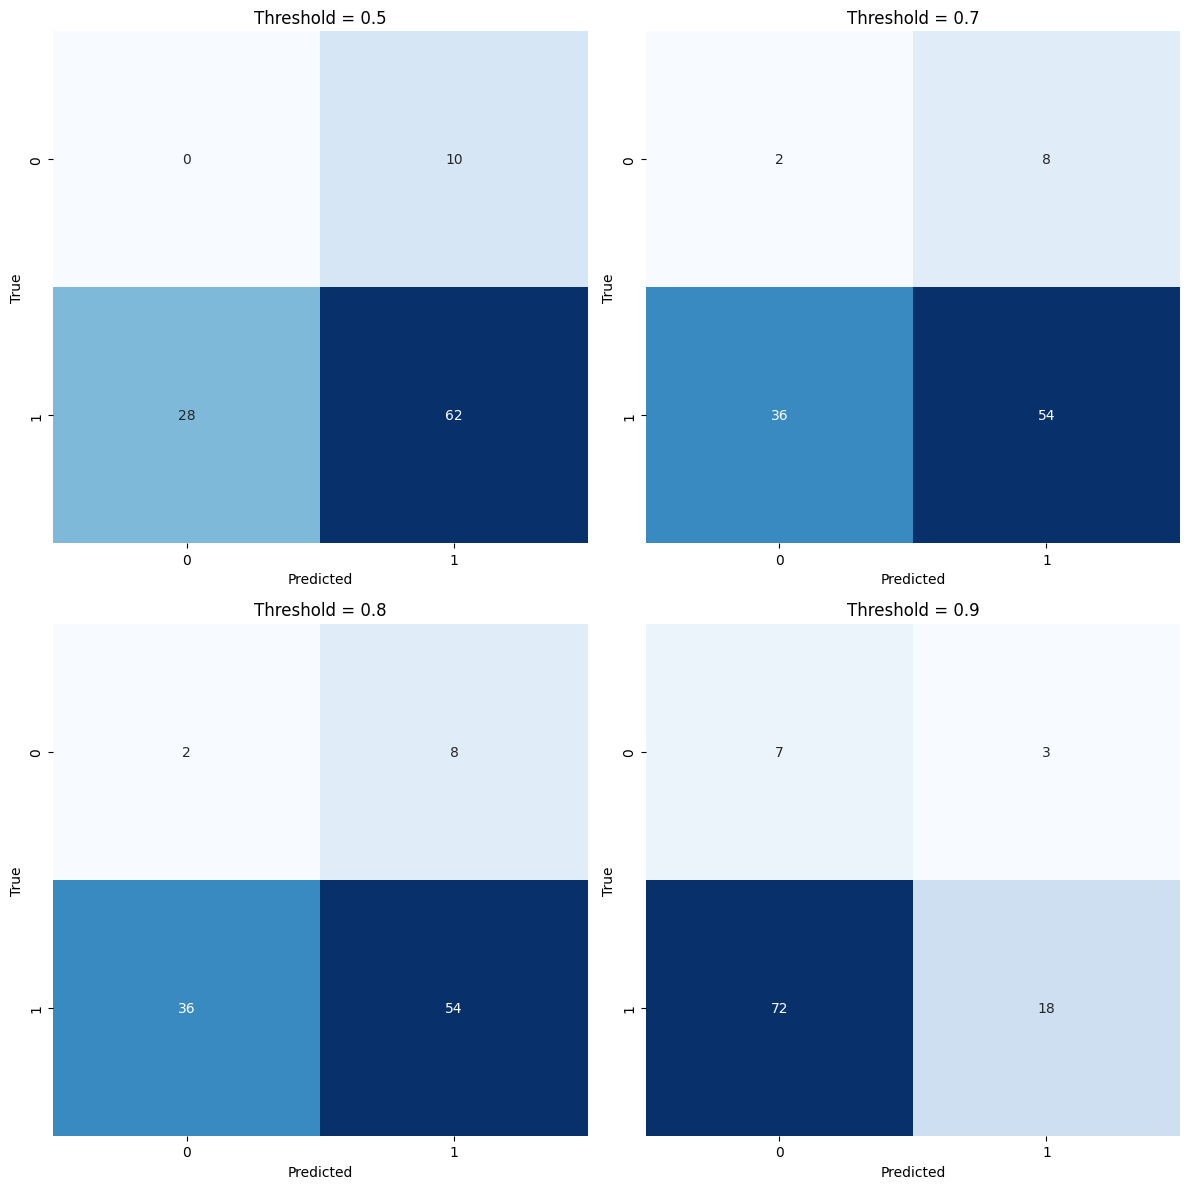

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/result_fakempox_for_model_llama37b.csv'
df = pd.read_csv(file_path)

# Convert 'predict_value' column to numeric, forcing errors to NaN and then filling them with 0
df['predict_value'] = pd.to_numeric(df['predict_value'], errors='coerce').fillna(0)

# Binarize the 'predict_value' field for various thresholds
df['binarized_predict_0_5'] = df['predict_value'].apply(lambda x: 1 if x >= 0.5 else 0)
df['binarized_predict_0_7'] = df['predict_value'].apply(lambda x: 1 if x >= 0.7 else 0)
df['binarized_predict_0_8'] = df['predict_value'].apply(lambda x: 1 if x >= 0.8 else 0)
df['binarized_predict_0_9'] = df['predict_value'].apply(lambda x: 1 if x >= 0.9 else 0)

# True labels
y_true = df['true_value'].astype(int)

# Predicted labels for each threshold
y_pred_0_5 = df['binarized_predict_0_5']
y_pred_0_7 = df['binarized_predict_0_7']
y_pred_0_8 = df['binarized_predict_0_8']
y_pred_0_9 = df['binarized_predict_0_9']

# Generate confusion matrices for each threshold
conf_matrix_0_5 = confusion_matrix(y_true, y_pred_0_5)
conf_matrix_0_7 = confusion_matrix(y_true, y_pred_0_7)
conf_matrix_0_8 = confusion_matrix(y_true, y_pred_0_8)
conf_matrix_0_9 = confusion_matrix(y_true, y_pred_0_9)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for threshold 0.5
sns.heatmap(conf_matrix_0_5, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 0])
axes[0, 0].set_title('Threshold = 0.5')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')

# Plot for threshold 0.7
sns.heatmap(conf_matrix_0_7, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 1])
axes[0, 1].set_title('Threshold = 0.7')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

# Plot for threshold 0.8
sns.heatmap(conf_matrix_0_8, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 0])
axes[1, 0].set_title('Threshold = 0.8')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')

# Plot for threshold 0.9
sns.heatmap(conf_matrix_0_9, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 1])
axes[1, 1].set_title('Threshold = 0.9')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# Display the plot
plt.tight_layout()
plt.show()


In [34]:
data_temp= pd.read_csv("/content/result_fakempox_for_model_mixtral7b_temp_0.3.csv")
data_temp["model"]="llama37b"

In [35]:
data_temp.to_csv("fake_mpox_llama37b_temp_0.3.csv", index=False)